In [40]:
import numpy as np
"""from google.colab import drive
drive.mount('/content/drive')
!ls drive/'My Drive/YYY_deep_project_YYY'"""


"from google.colab import drive\ndrive.mount('/content/drive')\n!ls drive/'My Drive/YYY_deep_project_YYY'"

In [41]:
#%cd drive/'My Drive/YYY_deep_project_YYY'

In [42]:
def get_sequence(infile):

    while True:

        header = infile.readline()
        sequence = infile.readline()

        pdb = header[1:5]

        if not header or not sequence or set(sequence) == {'X'}:
            return
        
        yield header.strip()[1:], sequence.strip(), pdb

120


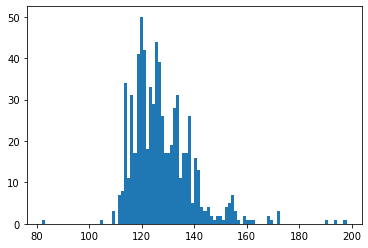

In [43]:
sequences = []
seq_to_pdb = {}
count = 0
with open('all_heavy.fasta') as infile:

        for header, sequence, pdb in get_sequence(infile):
            #if count < 500:
            sequences.append(list(sequence))
                #count += 1
            
            seq_to_pdb[sequence] = pdb
            
sequences = [seq for seq in sequences if len(seq) < 200]

import matplotlib.pyplot as plt
lengths = [len(seq) for seq in sequences]

mode = max(set(lengths), key=lengths.count)

print(mode)

plt.hist(lengths, bins=100)
plt.show()
#sequences = [seq for seq in sequences if len(seq) == mode]

# Take only shorter sequences to make it more quick



In [44]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    
    
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train-1]
    sequences_val = sequences[num_train:num_train+num_val-1]
    sequences_test = sequences[-num_test:-1]

    input_train = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_train]
    input_val = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_val]
    input_test = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_test]

    return (input_train, input_val, input_test)

(input_train, input_val, input_test) = create_datasets(sequences, Dataset)

In [45]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        
        from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
        
        self.model_type = 'Transformer'
        
        self.pos_encoder = PositionalEncoding(ninp, dropout)

        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        
        self.embed = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        
        self.ff = nn.Linear(ninp, ntoken)

        decoder_layers = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        
        self.transformer_decoder = TransformerDecoder(decoder_layers, nlayers)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.embed.weight.data.uniform_(-initrange, initrange)
        
        self.ff.bias.data.zero_()
        self.ff.weight.data.uniform_(-initrange, initrange)
        
        #self.transformer_decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask, seq_lengths):
        
        # utils.rnn lets you give (B,L,D) tensors where B is the batch size, L is the maxlength, if you use batch_first=True
        # Otherwise, give (L,B,D) tensors
        #seq_tensor = src.transpose(0,1) # (B,L,D) -> (L,B,D)
        
        seq_tensor = src
        # embed your sequences
        seq_tensor = self.embed(seq_tensor) * math.sqrt(self.ninp)
        
        # pack them up nicely
        #packed_input = pack_padded_sequence(seq_tensor, seq_lengths.numpy())
        
        src = self.pos_encoder(seq_tensor)
        
        output = self.transformer_encoder(src, src_mask)

        output = self.transformer_decoder(output, src_mask)
        #output = self.ff(output)

        return output

In [46]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [47]:

def generate_square_subsequent_mask(sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    
vocab = ['<pad>', "<sos>", "<eos>"] + ["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","X","Y"]
char_nums = {token:vocab.index(token) for token in vocab}

def batchify(data):
    
    # get the length of each seq in your batch
    seq_lengths = torch.LongTensor([len(seq) for seq in data])

    train_vectorized = [[char_nums[char] for char in seq] for seq in data]
    
    # dump padding everywhere, and place seqs on the left.
    # NOTE: you only need a tensor as big as your longest sequence
    seq_tensor = torch.zeros((len(train_vectorized), seq_lengths.max())).long()
    for idx, (seq, seqlen) in enumerate(zip(train_vectorized, seq_lengths)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    # SORT YOUR TENSORS BY LENGTH!
    seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
    seq_tensor = seq_tensor[perm_idx]

    return seq_tensor, seq_lengths


train_data, train_lengths = batchify(input_train)
val_data, val_lengths = batchify(input_train)
test_data, test_lengths = batchify(input_train)

train_data

tensor([[ 1, 18,  8,  ..., 15, 17,  2],
        [ 1,  6, 20,  ...,  0,  0,  0],
        [ 1, 16, 20,  ...,  0,  0,  0],
        ...,
        [ 1, 18,  8,  ...,  0,  0,  0],
        [ 1, 18,  8,  ...,  0,  0,  0],
        [ 1, 18, 13,  ...,  0,  0,  0]])

In [48]:
bptt = 60
max_len = max(map(len, sequences))
def get_batch(source, i):
    n_seqs = min(bptt, len(source) - 1 - i)
    data = torch.cat([train_data[i][:-1] for i in range(n_seqs)]).view(n_seqs,max_len+1)
    
    target = torch.cat([train_data[i][1:] for i in range(n_seqs)]).view(n_seqs,max_len+1).reshape(-1)
    
    return data, target


In [49]:
ntokens = len(vocab) # the size of vocabulary
emsize = 800 # embedding dimension
nhid = 400 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4 # the number of heads in the multiheadattention models
dropout = 0.5 # the dropout value

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#  ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)
criterion = nn.CrossEntropyLoss()

lr = 4.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#optimizer  = torch.optim.Adam(lr=lr, params=model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

train_losses = []
val_losses = []
model.to(device)
import sys
import time
def train():
    
    train_loss = 0
    
    n_batches = 0
    
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(vocab)
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        
        data, targets = get_batch(train_data, i)
    
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        
        output = model(data, src_mask, train_lengths)
        
        loss = criterion(output.view(-1, ntokens), targets)
        
        n_batches += 1
        train_loss += loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        
        # Soft, hard accuracy
        #o = list(output.view(-1, ntokens)[0])
        #t = targets
        #print(o,t)
        #hard_acc = sum([i for i in range(len(targets)) if o[i] == t[i]])/len(targets)
        
        optimizer.step()
        
        total_loss += loss.item()
        log_interval = 1
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}|'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    
    train_losses.append(train_loss/n_batches)

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            
            data, targets = data.to(device), targets.to(device)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask, val_lengths)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
            
    return total_loss / (len(data_source) - 1)


In [51]:
data, targets = get_batch(train_data, 0)
data, targets = data.to(device), targets.to(device)

src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)

out = model(data, src_mask, train_lengths)

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [14]:
best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    val_losses.append(val_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

| epoch   1 |     1/    9 batches | lr 4.00 | ms/batch 582.12 | loss 18.54 | ppl 112142794.21|
| epoch   1 |     2/    9 batches | lr 4.00 | ms/batch 293.06 | loss 11.68 | ppl 118098.64|
| epoch   1 |     3/    9 batches | lr 4.00 | ms/batch 287.07 | loss  6.45 | ppl   631.84|
| epoch   1 |     4/    9 batches | lr 4.00 | ms/batch 287.07 | loss 10.83 | ppl 50410.81|
| epoch   1 |     5/    9 batches | lr 4.00 | ms/batch 289.07 | loss  8.99 | ppl  8053.32|
| epoch   1 |     6/    9 batches | lr 4.00 | ms/batch 289.07 | loss  8.01 | ppl  3016.19|
| epoch   1 |     7/    9 batches | lr 4.00 | ms/batch 287.06 | loss  6.20 | ppl   492.72|
| epoch   1 |     8/    9 batches | lr 4.00 | ms/batch 289.07 | loss  7.77 | ppl  2358.47|
| epoch   1 |     9/    9 batches | lr 4.00 | ms/batch 122.02 | loss 14.62 | ppl 2231860.75|
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  3.64s | valid loss 19.61 | valid ppl 328883532.23
------

-----------------------------------------------------------------------------------------
| end of epoch   8 | time:  3.63s | valid loss  2.35 | valid ppl    10.54
-----------------------------------------------------------------------------------------
| epoch   9 |     1/    9 batches | lr 2.52 | ms/batch 577.14 | loss  5.25 | ppl   191.09|
| epoch   9 |     2/    9 batches | lr 2.52 | ms/batch 288.07 | loss  2.51 | ppl    12.33|
| epoch   9 |     3/    9 batches | lr 2.52 | ms/batch 290.07 | loss  2.26 | ppl     9.61|
| epoch   9 |     4/    9 batches | lr 2.52 | ms/batch 293.07 | loss  2.29 | ppl     9.86|
| epoch   9 |     5/    9 batches | lr 2.52 | ms/batch 292.06 | loss  2.12 | ppl     8.36|
| epoch   9 |     6/    9 batches | lr 2.52 | ms/batch 291.07 | loss  2.60 | ppl    13.44|
| epoch   9 |     7/    9 batches | lr 2.52 | ms/batch 292.07 | loss  2.19 | ppl     8.95|
| epoch   9 |     8/    9 batches | lr 2.52 | ms/batch 289.07 | loss  2.27 | ppl     9.67|
| epoch   9 |     

| epoch  16 |     6/    9 batches | lr 1.76 | ms/batch 296.06 | loss  1.70 | ppl     5.46|
| epoch  16 |     7/    9 batches | lr 1.76 | ms/batch 292.07 | loss  1.75 | ppl     5.74|
| epoch  16 |     8/    9 batches | lr 1.76 | ms/batch 290.07 | loss  1.69 | ppl     5.43|
| epoch  16 |     9/    9 batches | lr 1.76 | ms/batch 122.02 | loss  2.02 | ppl     7.55|
-----------------------------------------------------------------------------------------
| end of epoch  16 | time:  3.73s | valid loss  1.55 | valid ppl     4.71
-----------------------------------------------------------------------------------------
| epoch  17 |     1/    9 batches | lr 1.67 | ms/batch 604.15 | loss  3.31 | ppl    27.45|
| epoch  17 |     2/    9 batches | lr 1.67 | ms/batch 301.07 | loss  1.68 | ppl     5.35|
| epoch  17 |     3/    9 batches | lr 1.67 | ms/batch 301.07 | loss  1.68 | ppl     5.37|
| epoch  17 |     4/    9 batches | lr 1.67 | ms/batch 298.07 | loss  1.68 | ppl     5.34|
| epoch  17 |     

| epoch  24 |     2/    9 batches | lr 1.17 | ms/batch 301.07 | loss  1.45 | ppl     4.28|
| epoch  24 |     3/    9 batches | lr 1.17 | ms/batch 295.08 | loss  1.46 | ppl     4.31|
| epoch  24 |     4/    9 batches | lr 1.17 | ms/batch 297.06 | loss  1.48 | ppl     4.39|
| epoch  24 |     5/    9 batches | lr 1.17 | ms/batch 296.07 | loss  1.48 | ppl     4.41|
| epoch  24 |     6/    9 batches | lr 1.17 | ms/batch 296.08 | loss  1.49 | ppl     4.42|
| epoch  24 |     7/    9 batches | lr 1.17 | ms/batch 284.07 | loss  1.48 | ppl     4.37|
| epoch  24 |     8/    9 batches | lr 1.17 | ms/batch 283.06 | loss  1.47 | ppl     4.35|
| epoch  24 |     9/    9 batches | lr 1.17 | ms/batch 119.02 | loss  1.80 | ppl     6.04|
-----------------------------------------------------------------------------------------
| end of epoch  24 | time:  3.68s | valid loss  1.29 | valid ppl     3.63
-----------------------------------------------------------------------------------------
| epoch  25 |     

-----------------------------------------------------------------------------------------
| end of epoch  31 | time:  3.54s | valid loss  1.14 | valid ppl     3.13
-----------------------------------------------------------------------------------------
| epoch  32 |     1/    9 batches | lr 0.77 | ms/batch 595.13 | loss  2.70 | ppl    14.81|
| epoch  32 |     2/    9 batches | lr 0.77 | ms/batch 295.07 | loss  1.34 | ppl     3.83|
| epoch  32 |     3/    9 batches | lr 0.77 | ms/batch 302.07 | loss  1.33 | ppl     3.79|
| epoch  32 |     4/    9 batches | lr 0.77 | ms/batch 292.07 | loss  1.34 | ppl     3.83|
| epoch  32 |     5/    9 batches | lr 0.77 | ms/batch 289.07 | loss  1.33 | ppl     3.79|
| epoch  32 |     6/    9 batches | lr 0.77 | ms/batch 281.06 | loss  1.35 | ppl     3.85|
| epoch  32 |     7/    9 batches | lr 0.77 | ms/batch 287.07 | loss  1.34 | ppl     3.83|
| epoch  32 |     8/    9 batches | lr 0.77 | ms/batch 280.06 | loss  1.35 | ppl     3.86|
| epoch  32 |     

| epoch  39 |     6/    9 batches | lr 0.54 | ms/batch 280.06 | loss  1.29 | ppl     3.62|
| epoch  39 |     7/    9 batches | lr 0.54 | ms/batch 281.06 | loss  1.28 | ppl     3.61|
| epoch  39 |     8/    9 batches | lr 0.54 | ms/batch 281.06 | loss  1.27 | ppl     3.55|
| epoch  39 |     9/    9 batches | lr 0.54 | ms/batch 119.03 | loss  1.56 | ppl     4.75|
-----------------------------------------------------------------------------------------
| end of epoch  39 | time:  3.53s | valid loss  1.05 | valid ppl     2.84
-----------------------------------------------------------------------------------------
| epoch  40 |     1/    9 batches | lr 0.51 | ms/batch 562.13 | loss  2.56 | ppl    12.89|
| epoch  40 |     2/    9 batches | lr 0.51 | ms/batch 281.06 | loss  1.28 | ppl     3.59|
| epoch  40 |     3/    9 batches | lr 0.51 | ms/batch 281.06 | loss  1.27 | ppl     3.56|
| epoch  40 |     4/    9 batches | lr 0.51 | ms/batch 280.06 | loss  1.27 | ppl     3.58|
| epoch  40 |     

| epoch  47 |     2/    9 batches | lr 0.36 | ms/batch 280.06 | loss  1.23 | ppl     3.41|
| epoch  47 |     3/    9 batches | lr 0.36 | ms/batch 281.06 | loss  1.22 | ppl     3.39|
| epoch  47 |     4/    9 batches | lr 0.36 | ms/batch 281.06 | loss  1.24 | ppl     3.45|
| epoch  47 |     5/    9 batches | lr 0.36 | ms/batch 282.06 | loss  1.22 | ppl     3.40|
| epoch  47 |     6/    9 batches | lr 0.36 | ms/batch 280.06 | loss  1.23 | ppl     3.41|
| epoch  47 |     7/    9 batches | lr 0.36 | ms/batch 279.96 | loss  1.22 | ppl     3.40|
| epoch  47 |     8/    9 batches | lr 0.36 | ms/batch 281.07 | loss  1.22 | ppl     3.39|
| epoch  47 |     9/    9 batches | lr 0.36 | ms/batch 118.02 | loss  1.50 | ppl     4.49|
-----------------------------------------------------------------------------------------
| end of epoch  47 | time:  3.53s | valid loss  0.98 | valid ppl     2.66
-----------------------------------------------------------------------------------------
| epoch  48 |     

-----------------------------------------------------------------------------------------
| end of epoch  54 | time:  3.74s | valid loss  0.94 | valid ppl     2.56
-----------------------------------------------------------------------------------------
| epoch  55 |     1/    9 batches | lr 0.24 | ms/batch 567.14 | loss  2.41 | ppl    11.10|
| epoch  55 |     2/    9 batches | lr 0.24 | ms/batch 289.06 | loss  1.20 | ppl     3.31|
| epoch  55 |     3/    9 batches | lr 0.24 | ms/batch 300.07 | loss  1.19 | ppl     3.27|
| epoch  55 |     4/    9 batches | lr 0.24 | ms/batch 300.07 | loss  1.20 | ppl     3.31|
| epoch  55 |     5/    9 batches | lr 0.24 | ms/batch 293.07 | loss  1.20 | ppl     3.32|
| epoch  55 |     6/    9 batches | lr 0.24 | ms/batch 280.07 | loss  1.19 | ppl     3.30|
| epoch  55 |     7/    9 batches | lr 0.24 | ms/batch 287.07 | loss  1.20 | ppl     3.31|
| epoch  55 |     8/    9 batches | lr 0.24 | ms/batch 285.06 | loss  1.19 | ppl     3.28|
| epoch  55 |     

| epoch  62 |     6/    9 batches | lr 0.17 | ms/batch 283.06 | loss  1.17 | ppl     3.23|
| epoch  62 |     7/    9 batches | lr 0.17 | ms/batch 289.07 | loss  1.18 | ppl     3.26|
| epoch  62 |     8/    9 batches | lr 0.17 | ms/batch 283.06 | loss  1.18 | ppl     3.25|
| epoch  62 |     9/    9 batches | lr 0.17 | ms/batch 122.03 | loss  1.47 | ppl     4.34|
-----------------------------------------------------------------------------------------
| end of epoch  62 | time:  3.66s | valid loss  0.91 | valid ppl     2.50
-----------------------------------------------------------------------------------------
| epoch  63 |     1/    9 batches | lr 0.16 | ms/batch 577.13 | loss  2.36 | ppl    10.57|
| epoch  63 |     2/    9 batches | lr 0.16 | ms/batch 288.06 | loss  1.18 | ppl     3.24|
| epoch  63 |     3/    9 batches | lr 0.16 | ms/batch 295.07 | loss  1.18 | ppl     3.25|
| epoch  63 |     4/    9 batches | lr 0.16 | ms/batch 286.74 | loss  1.18 | ppl     3.26|
| epoch  63 |     

| epoch  70 |     2/    9 batches | lr 0.11 | ms/batch 291.07 | loss  1.16 | ppl     3.20|
| epoch  70 |     3/    9 batches | lr 0.11 | ms/batch 297.07 | loss  1.16 | ppl     3.20|
| epoch  70 |     4/    9 batches | lr 0.11 | ms/batch 296.07 | loss  1.17 | ppl     3.22|
| epoch  70 |     5/    9 batches | lr 0.11 | ms/batch 299.61 | loss  1.16 | ppl     3.20|
| epoch  70 |     6/    9 batches | lr 0.11 | ms/batch 299.51 | loss  1.17 | ppl     3.22|
| epoch  70 |     7/    9 batches | lr 0.11 | ms/batch 301.59 | loss  1.16 | ppl     3.19|
| epoch  70 |     8/    9 batches | lr 0.11 | ms/batch 300.06 | loss  1.16 | ppl     3.20|
| epoch  70 |     9/    9 batches | lr 0.11 | ms/batch 129.03 | loss  1.42 | ppl     4.15|
-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  3.74s | valid loss  0.90 | valid ppl     2.45
-----------------------------------------------------------------------------------------
| epoch  71 |     

-----------------------------------------------------------------------------------------
| end of epoch  77 | time:  3.73s | valid loss  0.89 | valid ppl     2.42
-----------------------------------------------------------------------------------------
| epoch  78 |     1/    9 batches | lr 0.07 | ms/batch 570.13 | loss  2.32 | ppl    10.22|
| epoch  78 |     2/    9 batches | lr 0.07 | ms/batch 285.06 | loss  1.16 | ppl     3.19|
| epoch  78 |     3/    9 batches | lr 0.07 | ms/batch 283.06 | loss  1.16 | ppl     3.18|
| epoch  78 |     4/    9 batches | lr 0.07 | ms/batch 290.07 | loss  1.15 | ppl     3.16|
| epoch  78 |     5/    9 batches | lr 0.07 | ms/batch 292.07 | loss  1.17 | ppl     3.21|
| epoch  78 |     6/    9 batches | lr 0.07 | ms/batch 290.07 | loss  1.16 | ppl     3.18|
| epoch  78 |     7/    9 batches | lr 0.07 | ms/batch 287.07 | loss  1.15 | ppl     3.16|
| epoch  78 |     8/    9 batches | lr 0.07 | ms/batch 286.06 | loss  1.17 | ppl     3.21|
| epoch  78 |     

| epoch  85 |     6/    9 batches | lr 0.05 | ms/batch 297.07 | loss  1.14 | ppl     3.14|
| epoch  85 |     7/    9 batches | lr 0.05 | ms/batch 306.18 | loss  1.15 | ppl     3.16|
| epoch  85 |     8/    9 batches | lr 0.05 | ms/batch 304.07 | loss  1.15 | ppl     3.16|
| epoch  85 |     9/    9 batches | lr 0.05 | ms/batch 126.03 | loss  1.42 | ppl     4.13|
-----------------------------------------------------------------------------------------
| end of epoch  85 | time:  3.74s | valid loss  0.88 | valid ppl     2.40
-----------------------------------------------------------------------------------------
| epoch  86 |     1/    9 batches | lr 0.05 | ms/batch 599.87 | loss  2.30 | ppl     9.99|
| epoch  86 |     2/    9 batches | lr 0.05 | ms/batch 297.99 | loss  1.14 | ppl     3.14|
| epoch  86 |     3/    9 batches | lr 0.05 | ms/batch 299.22 | loss  1.15 | ppl     3.17|
| epoch  86 |     4/    9 batches | lr 0.05 | ms/batch 299.97 | loss  1.15 | ppl     3.16|
| epoch  86 |     

| epoch  93 |     2/    9 batches | lr 0.03 | ms/batch 300.07 | loss  1.14 | ppl     3.12|
| epoch  93 |     3/    9 batches | lr 0.03 | ms/batch 300.07 | loss  1.15 | ppl     3.16|
| epoch  93 |     4/    9 batches | lr 0.03 | ms/batch 298.07 | loss  1.15 | ppl     3.17|
| epoch  93 |     5/    9 batches | lr 0.03 | ms/batch 299.07 | loss  1.15 | ppl     3.17|
| epoch  93 |     6/    9 batches | lr 0.03 | ms/batch 300.07 | loss  1.15 | ppl     3.14|
| epoch  93 |     7/    9 batches | lr 0.03 | ms/batch 300.07 | loss  1.14 | ppl     3.13|
| epoch  93 |     8/    9 batches | lr 0.03 | ms/batch 302.07 | loss  1.15 | ppl     3.16|
| epoch  93 |     9/    9 batches | lr 0.03 | ms/batch 128.03 | loss  1.43 | ppl     4.16|
-----------------------------------------------------------------------------------------
| end of epoch  93 | time:  3.79s | valid loss  0.87 | valid ppl     2.39
-----------------------------------------------------------------------------------------
| epoch  94 |     

-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  3.63s | valid loss  0.87 | valid ppl     2.38
-----------------------------------------------------------------------------------------


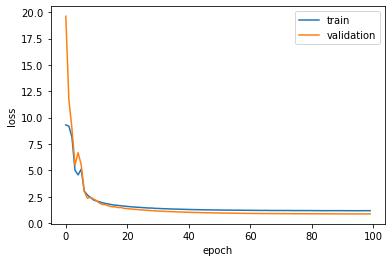

In [16]:

plt.figure()

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()



In [17]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  0.87 | test ppl     2.38


In [18]:
idx_to_letter = {val:key for key, val in char_nums.items()}

def sample_categorical(lnprobs, temperature=1.0):
    """
    Sample an element from a categorical distribution
    :param lnprobs: Outcome log-probabilities
    :param temperature: Sampling temperature. 1.0 follows the given distribution,
        0.0 returns the maximum probability element.
    :return: The index of the sampled element.
    """

    if temperature == 0.0:
        return lnprobs.argmax()
    p = F.softmax(lnprobs / temperature, dim=1)

    #print("softmaxed probs:", p)
    
    return dist.Categorical(p).sample()

def sample_sentence(model, query, max_len = 140, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    while len(query) < max_len and '<eos>' not in query:
        query_tensor, seq_lengths = batchify([query])
        query_tensor = query_tensor.to(device)
    
        src_mask = model.generate_square_subsequent_mask(len(query_tensor)).to(device)
        
        output = model(query_tensor, src_mask, torch.Tensor([len(query)])).view(-1, ntokens)
        
        next_char_idx = sample_categorical(output, temperature) #0.5
                
        try:
            query += [idx_to_letter[int(next_char_idx[-1])]]
        except IndexError:
            query += [idx_to_letter[int(next_char_idx)]]
            
    return query


In [19]:
import torch.distributions as dist
ntokens = len(vocab)

for _ in range(10):
    sample = sample_sentence(model, ["<sos>","E"], max_len = 500, temperature=0.9)

    print(len(sample), " ".join(sample))
    

60 <sos> E P T F S S S G G T A S L V Y G L V T K G G S S G T W M M Y T A M N D Q M Y T C T A S S G G L V P D T P V T P A A K <eos>
119 <sos> E V L V T T V T G Y F T Y G L V T V D T V T V T V L V T V T V T A R D T L K K G L V T T S S G L V S N S S G Q M M Y A R Q G L Q M S S L Q T V S S G T S G S A K L V T Y F A V A M Y W V T S S S G V S G T A S Y F A G T L V G E W L V K K <eos>
500 <sos> E G Y W G T S S G G L V T T A V K R Q M Y Y Y F P G V K N E P V T V T Y W Q M Y Y F P S G D K N N S S E P V T V K I E W T F T V T S L V T V T Q M G G G Y Y G L V T L V S Q K G G L Q M Y F T F T V S T S G V T A G L V T Y P G L V T S G S G T W Y T A K G R Q K G G R D T S V N S S L V A K S G V T S T S L Q M Y F L V T Y T V T Y W V T S G G L V T V T H T W V Q M Y W V T P S G Q M N T V T T P S D N L Q T P S G T V F T V K G Q M S L V T T S Y F P G G G S G Y F T T T T P V T L V T L V T V S L V T A V T V H I L Q M Y F S S G S S T V R D T P P G Y W L V T V T L Q P V T N S V T S L V L Q M G T A R D T F T S G G I